In [ ]:
## Download and preprocess TF motifs from databases
## CIS-BP 2.0
## JASPAR 2020
## BANP motif from Grand2021
## see 'runall' script in each databases/*/ folder for pre-preproccing steps.

## After pre-processing all of the invdividual databases run
##      bin/runall.tomtom.v2.0beta-human
## to compute the pair-wise similarity for all the motifs.
## Results are stored in 'results/tomtom'.


In [ ]:
import pandas as pd
import numpy as np

In [69]:
# Import CIS-BP metadata
cisbp = pd.read_table('databases/cisbp_v2.0/TF_Information.txt')
cisbp_is_direct = cisbp['TF_Status']=='D' # motifs which the motif model is a direct measurment; i.e., not inferred

# These are the motifs that exist in the MEME file
cisbp_motifs = !grep "MOTIF" databases/cisbp_v2.0/all.motifs.meme | cut -d" " -f2

cisbp_df = cisbp[cisbp_is_direct][['Motif_ID', 'DBID.1', 'TF_Name', 'Family_Name', 'Motif_Type', 'PMID']]
cisbp_df.drop_duplicates(inplace=True)

col_dict = {
    'Motif_ID': 'motif_id',
    'DBID.1': 'source_id',
    'TF_Name': 'tf_name',
    'Family_Name': 'family_name',
    'Motif_Type': 'motif_type'
}
cisbp_df = cisbp_df.rename(columns=col_dict).set_index('motif_id')

cisbp_df = cisbp_df.loc[cisbp_motifs]

SELEX                2578
ChIP-seq              530
Misc                  484
PBM                   252
Transfac              225
ChIP-seq+ChIP-exo     221
SMiLE-seq              52
COMPILED                4
ChIP-exo                3
B1H                     1
Unknown                 1
Name: motif_type, dtype: int64

In [71]:
# Import JASPAR2022 metadata

# These are the human only motifs; used the JASPAR search tool on website and downloaded all motifs from cart
jaspar2022 = !grep "MOTIF" databases/jaspar2022/20220412170304_JASPAR2022_combined_matrices_20949_meme.meme | cut -d" " -f2

# Only get JASPAR motifs not in CIS-BP
# Note: some Taipale motifs are present in the JASPAR that might also be in CIS-BP

jaspar_motifs = list(set(jaspar2022) - set(cisbp_df['source_id']))

from pyjaspar import jaspardb
jdb_obj = jaspardb(release='JASPAR2022')

motif_id = []
dbid = []
tf_name = []
tf_family_name = []
pmid = []
motif_type = []

for m in jaspar_motifs:
    motif = jdb_obj.fetch_motif_by_id(m)
    
    motif_id.append(m)
    dbid.append(m)
    
    tf_name.append(motif.name)
    tf_family_name.append(motif.tf_class)
    pmid.append(motif.medline)
    motif_type.append('Uknown')
    
jaspar2022_df = pd.DataFrame(
    {
        'motif_id': motif_id,
        'source_id': dbid,
        'tf_name': tf_name,
        'family_name': tf_family_name,
        'motif_type': motif_type,
        'PMID': pmid
    }
).set_index('motif_id')



In [72]:
# Get BANP motif from Grand et al. 2021

grand2021 = !grep "MOTIF" databases/Grand2021/BANP.meme | cut -d" " -f2

motif_id = []
dbid = []
tf_name = []
tf_family_name = []
pmid = []
motif_type = []

for m in grand2021:    
    motif_id.append(m)
    dbid.append('BANP')
    
    tf_name.append('BANP')
    tf_family_name.append('Unknown')
    pmid.append(34234345)
    motif_type.append('ChIP-seq')
    
grand2021_df = pd.DataFrame(
    {
        'motif_id': motif_id,
        'source_id': dbid,
        'tf_name': tf_name,
        'family_name': tf_family_name,
        'motif_type': motif_type,
        'PMID': pmid
    }
).set_index('motif_id')


In [120]:
#Combine motif metadata.

motifs = cisbp_df.index.tolist()
motifs += jaspar_motifs
motifs += grand2021 
len(motifs)

df_motif_info = pd.concat([cisbp_df, jaspar2022_df, grand2021_df])
df_motif_info['motif_type'].value_counts()

SELEX                2578
Uknown                841
ChIP-seq              531
Misc                  484
PBM                   252
Transfac              225
ChIP-seq+ChIP-exo     221
SMiLE-seq              52
COMPILED                4
ChIP-exo                3
B1H                     1
Unknown                 1
Name: motif_type, dtype: int64

In [77]:
# Load up the TOMTOM results
tomtom = pd.read_table('results/tomtom/tomtom.all.txt').rename(columns={'#Query ID': 'Query ID'})
sim = tomtom.pivot(index='Query ID', columns='Target ID', values='E-value')
cols = sim.columns.intersection(motifs)
rows = sim.index.intersection(motifs)

In [78]:
sim = sim[cols].loc[rows]
sim.fillna(100, inplace=True)
sim = -np.log10(sim)
sim[np.isinf(sim)] = 10

sim.head()

Target ID,BANP_Grand2021,M00217_2.00,M00218_2.00,M00219_2.00,M00220_2.00,M00221_2.00,M00222_2.00,M00223_2.00,M00224_2.00,M00225_2.00,...,MA1979.1,MA1980.1,MA1981.1,MA1982.1,MA1983.1,MA1984.1,MA1985.1,MA1986.1,MA1987.1,MA2003.1
Query ID,,,,,,,,,,,,,,,,,,,,,
BANP_Grand2021,15.266056,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.0,-2.0,-2.0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
M00217_2.00,-2.000000,19.561752,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.0,-2.0,-2.0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
M00218_2.00,-2.000000,-2.000000,12.926018,12.926018,-2.000000,-2.000000,-2.000000,-2.0,-2.0,-2.0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
M00219_2.00,-2.000000,-2.000000,12.830975,12.830975,-2.000000,-2.000000,-2.000000,-2.0,-2.0,-2.0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
M00220_2.00,-2.000000,-2.000000,-2.000000,-2.000000,10.000318,2.731048,0.332751,-2.0,-2.0,-2.0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0


In [116]:
# Cluster the square matrix

from scipy.cluster.hierarchy import fcluster, linkage, dendrogram

Z = linkage(sim, method = 'complete', metric = 'correlation')

cl = fcluster(Z, 0.7, criterion='distance')
o = dendrogram(Z, no_plot=True)['leaves']

print(f'Number of motif clusters: {max(cl)}')

motif_annot_df = pd.DataFrame({'motif_id':sim.index, 'cluster':cl}).merge(df_motif_info.reset_index(), on='motif_id', how='left').set_index('motif_id')
motif_annot_df.head()

Number of motif clusters: 693


,cluster,source_id,tf_name,family_name,motif_type,PMID
motif_id,,,,,,
BANP_Grand2021,312,BANP,BANP,Unknown,ChIP-seq,34234345
M00217_2.00,52,ZNF200_H322Y,ZNF200,C2H2 ZF,PBM,27013732
M00218_2.00,690,ZNF200_REF,ZNF200,C2H2 ZF,PBM,27013732
M00219_2.00,690,ZNF200_S265Y,ZNF200,C2H2 ZF,PBM,27013732
M00220_2.00,83,SNAI2_D119E,SNAI2,C2H2 ZF,PBM,27013732


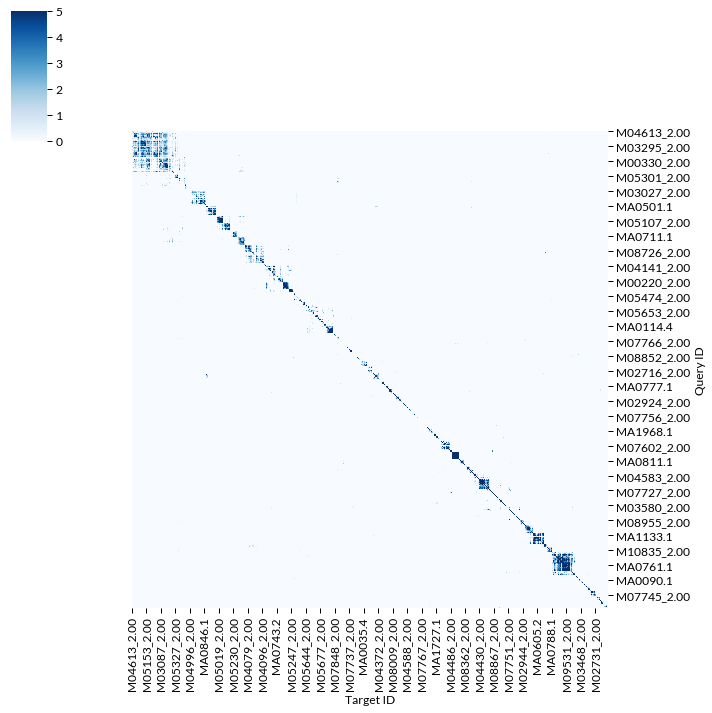

In [127]:
# Heatmap plot

import matplotlib.pyplot as plt
import seaborn as sns

sns.clustermap(sim.iloc[o,o], vmin=0, vmax=5, row_cluster=False, col_cluster=False, cmap='Blues')

plt.savefig('results/heatmap.png')

In [106]:
def relative_info_content(pwm):
    p = pwm/np.sum(pwm, axis = 1)[:,np.newaxis]
    ic = 2+np.sum(p*np.nan_to_num(np.log2(p)), axis = 1)
    ric = p*ic[:,np.newaxis]
    return ric

import warnings
warnings.filterwarnings('ignore')

def process_cluster(df, tomtom_df):
    
    import os.path
    
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as mgridspec
    
    from genome_tools.plotting import sequence
    
    seed_motif = df.index[0]
    motifs = df.index
    
    rows = (tomtom_df['Query ID'] == seed_motif) & (tomtom_df['Target ID'].isin(motifs))
    pairwise_df = tomtom_df[rows]
    
    w = pairwise_df['Target consensus'].str.len()
    left = min(-pairwise_df['Optimal offset'])
    l_offset = -left - pairwise_df['Optimal offset']
    right = max(l_offset + w)
    r_offset = right - w - l_offset
    
    alignment_df = pairwise_df.drop(['Query ID', 'Optimal offset', 'p-value', 'E-value', 'q-value', 'Overlap', 'Query consensus'], axis=1)
    alignment_df.loc[:,'w'] = w
    alignment_df.loc[:,'l_offset'] = l_offset
    alignment_df.loc[:,'r_offset'] = r_offset
    alignment_df.columns = ['motif', 'consensus', 'strand', 'w', 'l_offset', 'r_offset']
    
    alignment_df.reset_index(drop=True, inplace=True)
    alignment_df = alignment_df.merge(df.reset_index(), left_on='motif', right_on='motif_id')
    
    alignment_df.sort_values(by='tf_name', inplace=True)
    alignment_df.reset_index(inplace=True)

    n = len(alignment_df)
    l = min(alignment_df['l_offset'])
    r = max(alignment_df['r_offset'] + alignment_df['w'])
    w = r - l
    
    summed_pwm = np.zeros((4, w))
    
    for i, row in alignment_df.iterrows():
        
        motif_id = row['motif']
        rc = row['strand'] == '-'
        left = row['l_offset']
        width = row['w']

        motif_pfm = os.path.join('results/pfms/', motif_id + '.pfm')
        pwm = np.loadtxt(motif_pfm)
    
        if rc:
            pwm = pwm[::-1,::-1]
            
        extended_pwm = np.ones((4, w)) * 0.25
        extended_pwm[:,left:left+width] = pwm

        summed_pwm += extended_pwm
        
    avg_pwm = (summed_pwm/n).T
 
    ic = relative_info_content(avg_pwm)
    total_ic = ic.sum(axis=1)

    cdf = np.cumsum(total_ic)/np.sum(total_ic)
    s = np.where(cdf > 0.05)[0][0]
    e = np.where(cdf > 0.95)[0][0] + 1    

    avg_pwm = avg_pwm[s:e,:]
    
    ## plot
    
    fig = plt.figure()
    fig.set_size_inches((w+2)*.125+2, (n+1)*0.5+1)
    
    gs = mgridspec.GridSpec(n+1, 1)
    
    for i, row in alignment_df.iterrows():
        ax = fig.add_subplot(gs[i+1, :])
        
        motif_id = row['motif']
        rc = row['strand'] == '-'
        left = row['l_offset']
        width = row['w']

        motif_pfm = os.path.join('results/pfms/', motif_id + '.pfm')
        pwm = np.loadtxt(motif_pfm)
    
        if rc:
            pwm = pwm[::-1,::-1]
        
        sequence.seq_plot(relative_info_content(pwm.T), ax=ax, offset=left)

        ax.axvspan(l-1, s, fc='lightgrey', alpha=0.5)
        ax.axvspan(e, r+1, fc='lightgrey', alpha=0.5)
        
        ax.set_xlim(left=l-1, right=r+1)
        ax.set_ylim(bottom=0, top=2.1)

        ax.xaxis.set_visible(False)
        ax.set_yticks([])
        
        source_id = str(row['source_id'])
        source_id = source_id[:10] + '...' if len(source_id) > 10 else source_id
        tf_name = str(row['tf_name'])  + '(' + str(row['motif_type']) + ')'
        
        ax.set_ylabel(tf_name + '\n (' + source_id + ')', rotation=0, ha='right', va='center', fontname="IBM Plex Mono", fontsize='medium')

    # Archetype motif
    ax = fig.add_subplot(gs[0,:])

    sequence.seq_plot(relative_info_content(avg_pwm), ax=ax, offset=s)

    ax.set_xlim(left=l-1, right=r+1)
    ax.set_ylim(bottom=0, top=2.1)
    ax.xaxis.set_visible(False)
    ax.set_yticks([])

    ax.axvspan(s, e, fc='none', ec='r', lw=2, clip_on=False)
    [ax.spines[loc].set_visible(False) for loc in ['top', 'bottom', 'left', 'right']]

    ax.set_ylabel('Archetype\nconsensus', rotation=0, ha='right', va='center', fontname="IBM Plex Mono", fontsize='large', fontweight='bold', color='r')
    
    cluster_id = 'AC' + str(alignment_df['cluster'][0]).zfill(4)
    gene_family = alignment_df['tf_name'].str.replace('[\-0-9]+$', '').value_counts().index[:2].str.cat(sep='/')
    dbd = alignment_df['family_name'].astype(str).value_counts().index[0].replace(' ', '_')
    cluster_name = cluster_id + ':' + gene_family + ':' + dbd

    figw, figh = fig.get_size_inches()
    height_frac = (figh-0.75)/figh
    
   
    
    gs.update(left=1-((figw-1.75)/figw), right=(figw-0.25)/figw, top=(figh-0.75)/figh, bottom=1-((figh-0.25)/figh))
    
    fig.suptitle(cluster_name.upper(), fontname="IBM Plex Mono", fontweight='bold', fontsize='large', y=1-(.5/figh), va='center')
    plt.savefig(f'results/clusters/{cluster_id}.pdf')
    plt.savefig(f'results/clusters/{cluster_id}.png')
    
    #
    w = avg_pwm.shape[0]
    
    fig = plt.figure()
    #fig.set_size_inches(w*0.125+0.5, 0.75)
    fig.set_size_inches(w*0.125, 0.5)
    
    figw, figh = fig.get_size_inches() 
    
    gs = mgridspec.GridSpec(1, 1)
    #gs.update(left=1-((figw-0.25)/figw), right=(figw-0.25)/figw, top=1-(0.25/figh), bottom=0)
    gs.update(left=0, right=1, top=1, bottom=0)

    ax = fig.add_subplot(gs[:,:])
    
    sequence.seq_plot(relative_info_content(avg_pwm), ax=ax)
    
    ax.set_xlim(left=0, right=w)
    ax.set_ylim(bottom=0, top=2.1)
    
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    [ax.spines[loc].set_visible(False) for loc in ['top', 'bottom', 'left', 'right']]
    
    plt.savefig(f'results/clusters/logos/{cluster_id}.pdf')
    plt.savefig(f'results/clusters/logos/{cluster_id}.png')
    
    header_line =  cluster_name + '\n'
    mat = pd.DataFrame(avg_pwm.T, index=['A:', 'C:', 'G:', 'T:']).to_string(header=False)
    return header_line + mat

AC0312:ZBTB/BANP:C2H2_ZF
A:  0.018855  0.086122  0.017765  0.004015  0.027790  0.008768  0.005723  0.740165  0.013195  0.707890
C:  0.103755  0.868177  0.117672  0.986213  0.003217  0.957978  0.007065  0.084750  0.066475  0.083700
G:  0.043855  0.029850  0.029797  0.003047  0.956368  0.002715  0.983200  0.123970  0.723542  0.161967
T:  0.833533  0.015850  0.834760  0.006725  0.012627  0.030540  0.004015  0.051115  0.196790  0.046440


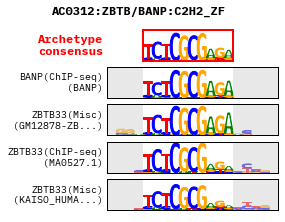

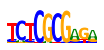

In [107]:
cluster = 312

df = motif_annot_df.groupby('cluster').get_group(cluster)
pwm = process_cluster(df, tomtom)

print(pwm)

In [ ]:
import matplotlib.pyplot as plt

with open('results/consensus_pwms.uniprobe', 'w') as fh:
    with plt.ioff():
        for cluster, df in motif_annot_df.groupby('cluster'):
            consensus_pwm = process_cluster(df, tomtom)
            fh.write(consensus_pwm + '\n\n')

In [109]:
info = motif_annot_df.groupby('cluster').size()
info.index = 'AC' + info.index.astype(str).str.zfill(4)
info.sort_values(ascending=False).to_csv('results/clusters.txt', sep='\t', header=None, index=True)

In [110]:
# Make the archetype motif MEME file

!uniprobe2meme results/consensus_pwms.uniprobe > results/consensus_pwms.meme

Converted 693 motifs.
Skipped 0 motifs.


In [117]:
# Output final motif metadata table

motif_annot_df['cluster'] = 'AC' + motif_annot_df['cluster'].astype(str).str.zfill(4)
motif_annot_df.to_csv('results/metadata.tsv', header=True, index=True, sep='\t')

In [118]:
motif_annot_df.head()

,cluster,source_id,tf_name,family_name,motif_type,PMID
motif_id,,,,,,
BANP_Grand2021,AC0312,BANP,BANP,Unknown,ChIP-seq,34234345
M00217_2.00,AC0052,ZNF200_H322Y,ZNF200,C2H2 ZF,PBM,27013732
M00218_2.00,AC0690,ZNF200_REF,ZNF200,C2H2 ZF,PBM,27013732
M00219_2.00,AC0690,ZNF200_S265Y,ZNF200,C2H2 ZF,PBM,27013732
M00220_2.00,AC0083,SNAI2_D119E,SNAI2,C2H2 ZF,PBM,27013732


In [124]:
# Make the HTML files
!bash bin/runall.make-html